**COMPONENT 1 - Vehicle Classification (Sedan, SUV)**

**Ultralytics Python Package Installation**

In [ ]:
# Checking the Installation of the Ultralytics Python Package and Import
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.107  Python-3.12.9 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Setup complete  (12 CPUs, 7.8 GB RAM, 393.8/458.8 GB disk)


In [3]:
# Installing the necessary Roboflow packages for use
%pip install roboflow --user

Note: you may need to restart the kernel to use updated packages.


In [6]:
from roboflow import Roboflow
rf = Roboflow(api_key="Zvxt56nX0pHHMqcqMRD6")
project = rf.workspace("datasci-rrabd").project("cars-dataset-75gpg")
version = project.version(1)
dataset = version.download("yolov11")
                

loading Roboflow workspace...
loading Roboflow project...


**YOLOv11 Nano Training and Evaluation**

In [ ]:
# Training the YOLOv11n (Nano) on the Roboflow Dataset at 3 epochs with images sized at 640
!yolo train model=yolo11n.pt data="C:\Users\gabri\Downloads\Cars-Dataset-1\data.yaml" epochs=3 imgsz=640

Ultralytics 8.3.107 🚀 Python-3.12.9 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=C:\Users\gabri\Downloads\Cars-Dataset-1\data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru


train: Scanning C:\Users\gabri\Downloads\Cars-Dataset-1\train\labels.cache... 1965 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1965/1965 [00:00<?, ?it/s]
train: Scanning C:\Users\gabri\Downloads\Cars-Dataset-1\train\labels.cache... 1965 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1965/1965 [00:00<?, ?it/s]

val: Scanning C:\Users\gabri\Downloads\Cars-Dataset-1\valid\labels.cache... 420 images, 1 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]
val: Scanning C:\Users\gabri\Downloads\Cars-Dataset-1\valid\labels.cache... 420 images, 1 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]
        1/3      2.13G     0.8254      3.077      1.445         39        640:   0%|          | 0/123 [00:02<?, ?it/s]
        1/3      2.13G     0.8254      3.077      1.445         39        640:   1%|          | 1/123 [00:02<05:22,  2.64s/it]
        1/3      2.17G     0.8362      3.005      1.417         49        640

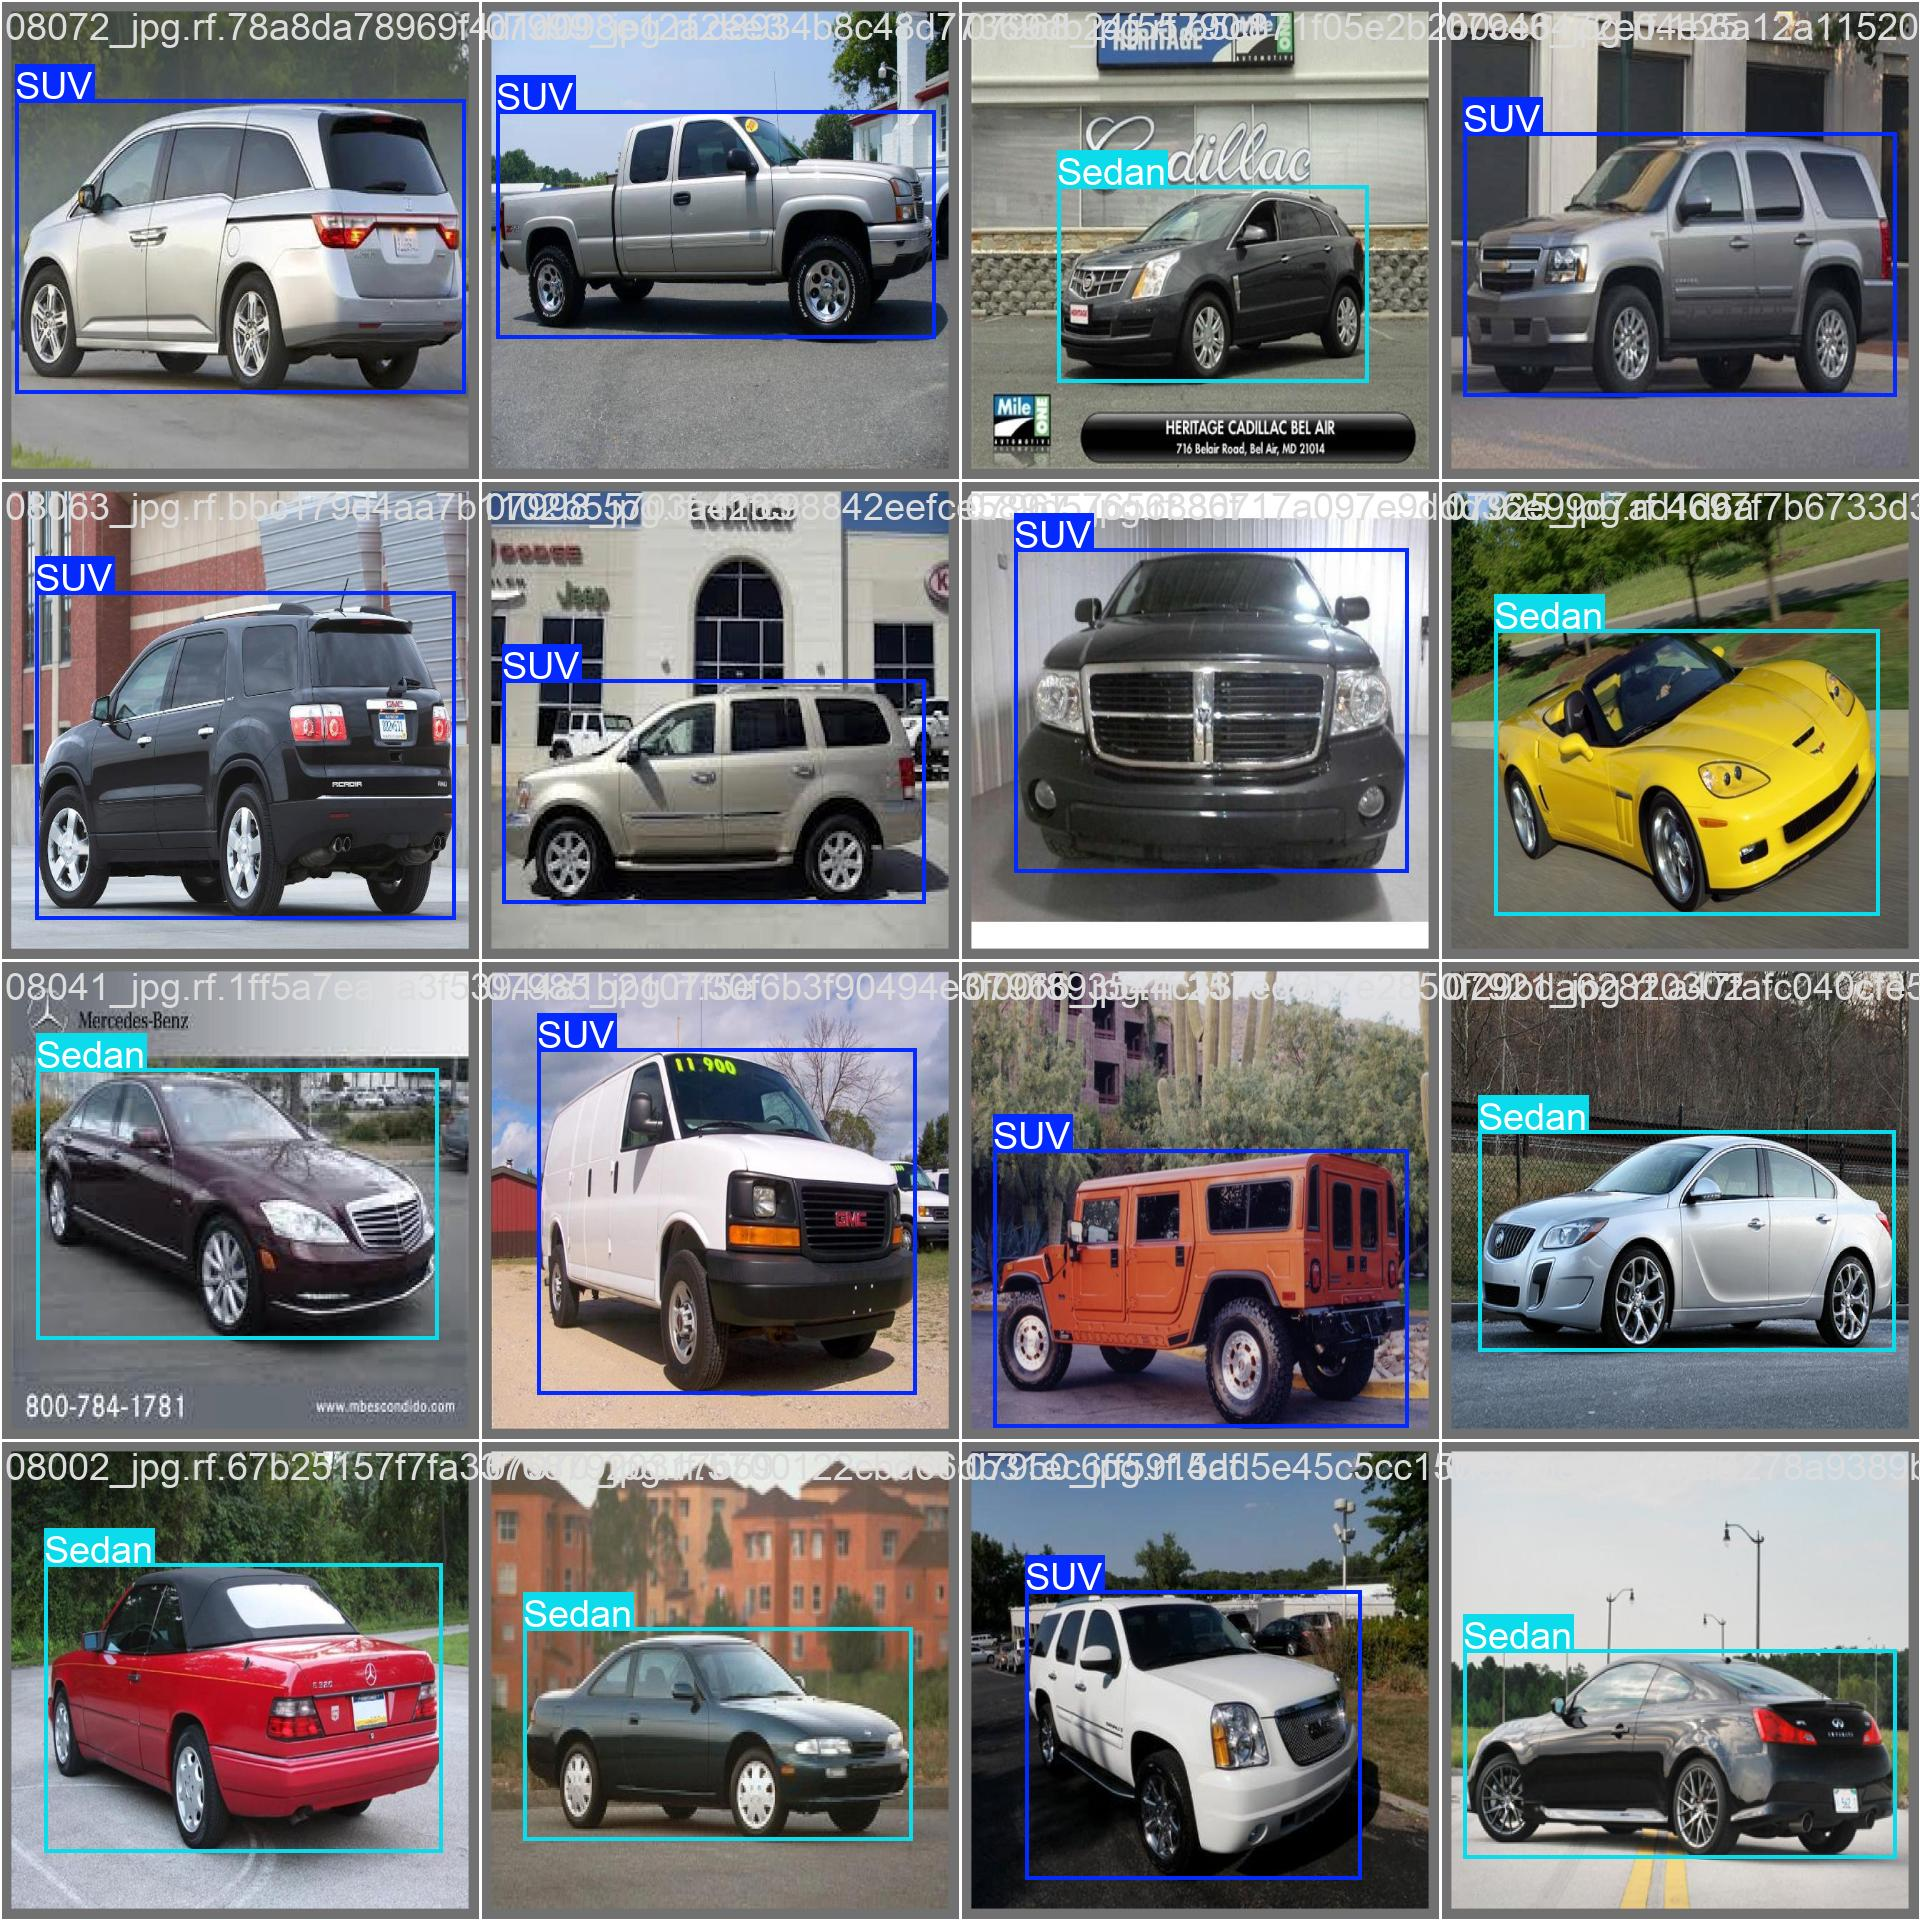

In [ ]:
# Running a video inference using the trained YOLOv11n (Nano) model
!yolo detect predict model=runs/detect/train2/weights/best.pt source="C:\Users\gabri\Downloads\5834623-uhd_3840_2160_24fps.mp4" 

Ultralytics 8.3.107 🚀 Python-3.12.9 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs

video 1/1 (frame 1/432) C:\Users\gabri\Downloads\5834623-uhd_3840_2160_24fps.mp4: 384x640 (no detections), 129.8ms
video 1/1 (frame 2/432) C:\Users\gabri\Downloads\5834623-uhd_3840_2160_24fps.mp4: 384x640 (no detections), 36.2ms
video 1/1 (frame 3/432) C:\Users\gabri\Downloads\5834623-uhd_3840_2160_24fps.mp4: 384x640 (no detections), 35.1ms
video 1/1 (frame 4/432) C:\Users\gabri\Downloads\5834623-uhd_3840_2160_24fps.mp4: 384x640 (no detections), 36.1ms
video 1/1 (frame 5/432) C:\Users\gabri\Downloads\5834623-uhd_3840_2160_24fps.mp4: 384x640 (no detections), 34.8ms
video 1/1 (frame 6/432) C:\Users\gabri\Downloads\5834623-uhd_3840_2160_24fps.mp4: 384x640 (no detections), 35.9ms
video 1/1 (frame 7/432) C:\Users\gabri\Downloads\5834623-uhd_3840_2160_24fps.mp4: 384x640 1 SUV, 35.5ms
video 1/1 (frame 8/4

**Faster R-CNN with ResNet50**

In [ ]:
# Importing the necessary modules for training Faster R-CNN with ResNet50
import os
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader                            # Required for custom dataset batch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor      # For Faster R-CNN classifier head
from torchvision import transforms as T                                     # For image transformations
from torchvision.ops import box_iou                                         # For calculating IoU between pred/target boxes

# Custom Dataset class for loading images and labels from Roboflow
class RoboflowYOLODataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):            # Constructor function to initialize dataset
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.transforms = transforms

    def __len__(self):  
        return len(self.image_files)

    def __getitem__(self, idx):         
        while True:
            img_filename = self.image_files[idx]
            img_path = os.path.join(self.images_dir, img_filename)
            label_path = os.path.join(self.labels_dir, img_filename.replace(".jpg", ".txt").replace(".png", ".txt"))

            image = Image.open(img_path).convert("RGB")
            w, h = image.size

            boxes = []
            labels = []

            if os.path.exists(label_path):                                                  # Check if label file exists
                with open(label_path, "r") as f:                                            # Read the label file
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) != 5:                                                 # Skip if not in YOLO format
                            continue
                        class_id, x_center, y_center, width, height = map(float, parts)     # Conversion of parts into float
                        x_center *= w                                                       
                        y_center *= h
                        width *= w
                        height *= h
                        x_min = x_center - width / 2
                        y_min = y_center - height / 2
                        x_max = x_center + width / 2
                        y_max = y_center + height / 2

                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(int(class_id) + 1)

            if len(boxes) == 0:                                     # Checking for bounding boxes
                idx = (idx + 1) % len(self.image_files)             # None, proceed to next image index
                continue
            else:                                                   # Conversion to tensors float32 and int64
                boxes = torch.tensor(boxes, dtype=torch.float32)
                labels = torch.tensor(labels, dtype=torch.int64)

                target = {
                    "boxes": boxes,
                    "labels": labels,
                    "image_id": torch.tensor([idx])
                }

                if self.transforms:
                    image = self.transforms(image)

                return image, target

# Transformation pipeline converting images to tensors
transform = T.Compose([T.ToTensor()])   

train_dataset = RoboflowYOLODataset(
    images_dir=r"C:\Users\gabri\Downloads\Cars-Dataset-1\train\images",
    labels_dir=r"C:\Users\gabri\Downloads\Cars-Dataset-1\train\labels",
    transforms=transform
)

# Creating DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Background, Sedan, SUV
num_classes = 3  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Using Faster R-CNN with ResNet50 backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Customizing the optimizer with SGD, Learning Rate of 0.005, Momentum of 0.9, and Weight Decay of 0.0005
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Function to evaluate the accuracy of the model on a batch of images
def evaluate_batch_accuracy(preds, targets, iou_threshold=0.5):
    correct = 0
    total = 0

    for pred, target in zip(preds, targets):
        if len(pred["boxes"]) == 0 or len(target["boxes"]) == 0:
            continue

        ious = box_iou(pred["boxes"].cpu(), target["boxes"].cpu())
        for i in range(len(target["boxes"])):
            max_iou, idx = ious[i].max(0)
            if max_iou >= iou_threshold:
                if pred["labels"][idx] == target["labels"][i]:
                    correct += 1
            total += 1

    return correct, total

num_epochs = 10 # Training the model for 10 epochs

# Loop printing of loss and accuracy per epoch
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_targets = 0

    for images, targets in train_loader:                                        # Looping of loading images and the targets
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)                                      # Calculation of the loss values
        losses = sum(loss for loss in loss_dict.values())                       # Sum of calculated loss values

        optimizer.zero_grad()           # Gradient resetting
        losses.backward()               # Backpropagation 
        optimizer.step()                # Optimizer step
        total_loss += losses.item()     # Accumulation of loss values
 
        with torch.no_grad():           # Model evaluation on the validation set
            model.eval()
            preds = model(images)
            correct, total = evaluate_batch_accuracy(preds, targets)
            total_correct += correct
            total_targets += total
            model.train()

    # Calculation of accuracy and printing with loss per epoch
    acc = (total_correct / total_targets) * 100 if total_targets > 0 else 0.0 
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")

# Saving the trained model with the specified filename
torch.save(model.state_dict(), "fasterrcnn_resnet50_cars.pth")
print("Model training complete and saved.")

**Faster R-CNN with ResNet50 Evaluation**

In [ ]:
import torch
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision import transforms
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 3  
modelsresnet50 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = modelsresnet50.roi_heads.box_predictor.cls_score.in_features                      # Number of input features for the classifier
modelsresnet50.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)            # Replacement of the pre-trained head 
modelsresnet50.load_state_dict(torch.load("fasterrcnn_resnet50_cars.pth", map_location=device)) # Loading the trained model
modelsresnet50.to(device)
modelsresnet50.eval() 

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Using the COCO annotations format of the Roboflow dataset
val_dataset = CocoDetection( 
    root=r"C:\Users\gabri\Downloads\Cars-Dataset-2\valid",
    annFile=r"C:\Users\gabri\Downloads\Cars-Dataset-2\valid\_annotations.coco.json",
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Loading the COCO annotations for evaluation
coco_gt = COCO(r"C:\Users\gabri\Downloads\Cars-Dataset-2\valid\_annotations.coco.json")

# Function to evaluate the model using COCO metrics
def coco_evaluate(model, data_loader, device, coco_gt):
    model.eval()
    results = []
    img_ids = []
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        with torch.no_grad():
            outputs = model(images)
        for i, output in enumerate(outputs):                        # Conversion of the output to numpy arrays
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            if isinstance(targets[i], list) and len(targets[i]) > 0:
                image_id = targets[i][0]['image_id']
            else:
                # If without annotation, get image_id from dataset
                image_id = val_dataset.ids[data_loader.batch_size * (images[0].shape[0] // data_loader.batch_size) + i]
            if hasattr(image_id, "item"):                           # Check if image_id is a tensor
                image_id = image_id.item()
            img_ids.append(image_id)                                # Appending image_id to the list
            for box, score, label in zip(boxes, scores, labels):    # Iteration through the boxes, scores, and labels
                x1, y1, x2, y2 = box
                width = x2 - x1
                height = y2 - y1
                result = {
                    "image_id": int(image_id),
                    "category_id": int(label),
                    "bbox": [float(x1), float(y1), float(width), float(height)],
                    "score": float(score)
                }
                results.append(result)

    if len(results) == 0:                                       # Checking if results exists, not null
        print("No detections to evaluate.")
        return 0.0
    coco_dt = coco_gt.loadRes(results)                          # Load the results into COCO format
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')      # COCO evaluation object
    coco_eval.evaluate()                                        # Performing evaluation
    coco_eval.accumulate()                                      # Accumulating results
    coco_eval.summarize()                                       # Summarizing results
    return coco_eval.stats[0]                                   # mAP@[IoU=0.50:0.95]

# Evaluation of the model on the validation set using COCO metrics
map_score_resnet = coco_evaluate(modelsresnet50, val_loader, device, coco_gt)
print(f"COCO mAP: {map_score_resnet:.4f}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.936
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.936
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.957
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.936
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.936
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.957
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

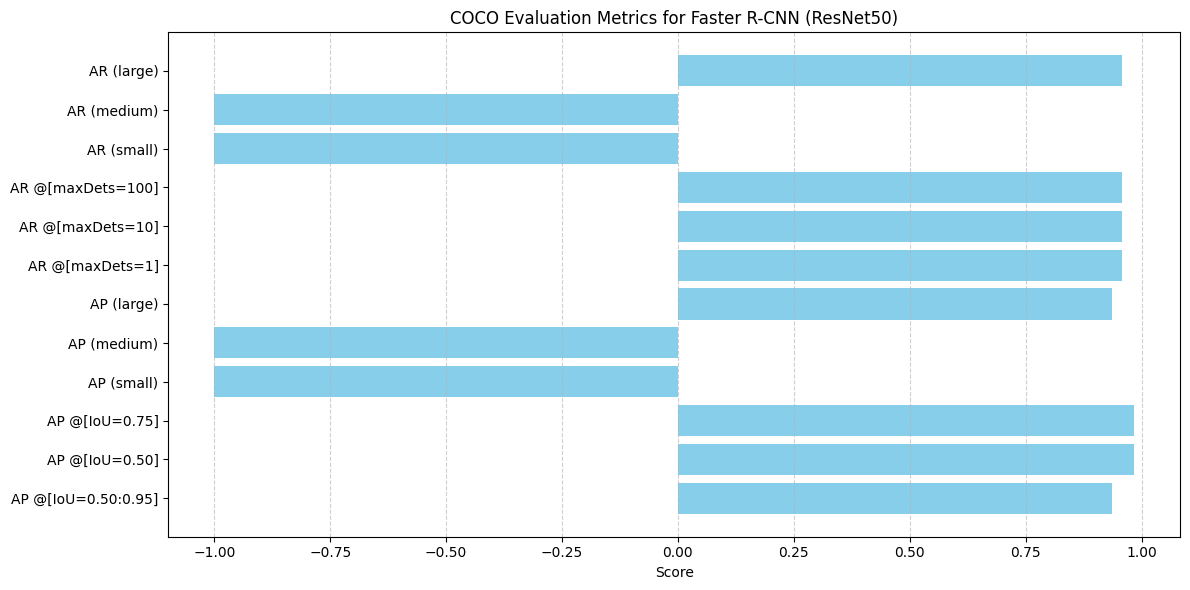

In [ ]:
import os
import torch
import torchvision
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision import transforms
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 3
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load("fasterrcnn_resnet50_cars.pth", map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([transforms.ToTensor()])

val_dataset = CocoDetection(
    root=r"C:\Users\gabri\Downloads\Cars-Dataset-2\valid",
    annFile=r"C:\Users\gabri\Downloads\Cars-Dataset-2\valid\_annotations.coco.json",
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Loading COCO annotations
coco_gt = COCO(r"C:\Users\gabri\Downloads\Cars-Dataset-2\valid\_annotations.coco.json")

# Evaluation function with full metric extraction
def coco_evaluate(model, data_loader, device, coco_gt):
    model.eval()
    results = []
    img_ids = []

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        with torch.no_grad():
            outputs = model(images)

        for i, output in enumerate(outputs):
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            if isinstance(targets[i], list) and len(targets[i]) > 0:
                image_id = targets[i][0]['image_id']
            else:
                image_id = val_dataset.ids[data_loader.batch_size * (images[0].shape[0] // data_loader.batch_size) + i]
            if hasattr(image_id, "item"):
                image_id = image_id.item()

            img_ids.append(image_id)

            for box, score, label in zip(boxes, scores, labels):
                x1, y1, x2, y2 = box
                width = x2 - x1
                height = y2 - y1
                result = {
                    "image_id": int(image_id),
                    "category_id": int(label),
                    "bbox": [float(x1), float(y1), float(width), float(height)],
                    "score": float(score)
                }
                results.append(result)

    if not results:
        print("No detections to evaluate.")
        return []

    # Load results into COCO format
    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval.stats 


# Running the evaluation and capturing metrics
coco_metrics = coco_evaluate(model, val_loader, device, coco_gt)

# Labels for COCO metrics
metric_labels = [
    "AP @[IoU=0.50:0.95]",
    "AP @[IoU=0.50]",
    "AP @[IoU=0.75]",
    "AP (small)",
    "AP (medium)",
    "AP (large)",
    "AR @[maxDets=1]",
    "AR @[maxDets=10]",
    "AR @[maxDets=100]",
    "AR (small)",
    "AR (medium)",
    "AR (large)"
]

# Plotting the COCO metrics
plt.figure(figsize=(12, 6))
plt.barh(metric_labels, coco_metrics, color='skyblue')
plt.title("COCO Evaluation Metrics for Faster R-CNN (ResNet50)")
plt.xlabel("Score")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import os
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T

class RoboflowYOLODataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        while True:  
            img_filename = self.image_files[idx]
            img_path = os.path.join(self.images_dir, img_filename)
            label_path = os.path.join(self.labels_dir, img_filename.replace(".jpg", ".txt").replace(".png", ".txt"))

            image = Image.open(img_path).convert("RGB")
            w, h = image.size

            boxes = []
            labels = []

            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) != 5:
                            continue
                        class_id, x_center, y_center, width, height = map(float, parts)
                        x_center *= w
                        y_center *= h
                        width *= w
                        height *= h
                        x_min = x_center - width / 2
                        y_min = y_center - height / 2
                        x_max = x_center + width / 2
                        y_max = y_center + height / 2

                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(int(class_id) + 1)

            if len(boxes) == 0:
                idx = (idx + 1) % len(self.image_files)  
                continue  
            else:
                boxes = torch.tensor(boxes, dtype=torch.float32)
                labels = torch.tensor(labels, dtype=torch.int64)

                target = {
                    "boxes": boxes,
                    "labels": labels,
                    "image_id": torch.tensor([idx])
                }

                if self.transforms:
                    image = self.transforms(image)

                return image, target

transform = T.Compose([
    T.ToTensor()
])

train_dataset = RoboflowYOLODataset(
    images_dir=r"C:\Users\gabri\Downloads\Cars-Dataset-1\train\images",
    labels_dir=r"C:\Users\gabri\Downloads\Cars-Dataset-1\train\labels",
    transforms=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

num_classes = 3  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f}")

# Saving the trained model with the specified filename
torch.save(model.state_dict(), "fasterrcnn_resnet50_cars.pth")
print("Model training complete and saved.")

Epoch [1/10] - Loss: 29.7534
Epoch [2/10] - Loss: 13.6615
Epoch [3/10] - Loss: 9.3634
Epoch [4/10] - Loss: 7.8821
Epoch [5/10] - Loss: 6.4346
Epoch [6/10] - Loss: 6.1180
Epoch [7/10] - Loss: 5.0446
Epoch [8/10] - Loss: 4.9042
Epoch [9/10] - Loss: 4.3805
Epoch [10/10] - Loss: 3.8254
Model training complete and saved.


In [ ]:
# (Optional) Performing video inference on this trained model
import cv2
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 3  # background + 2 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load("fasterrcnn_resnet50_cars.pth", map_location=device))
model.to(device)
model.eval()

# Performing inference on a video
input_path = "56310-479197605_tiny.mp4"
output_path = "annotated_output.mp4"

# Opening the video file
cap = cv2.VideoCapture(input_path)                  # Reading the video file
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))      # Getting the width of the video
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))    # Getting the height of the video
fps = cap.get(cv2.CAP_PROP_FPS)                     # Getting the FPS of the video

# Creating a VideoWriter object in saving the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')                            # MP4V as the video codec 
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))    # Creating the VideoWriter object

class_names = ["__background__", "Sedan", "SUV"]  

# Looping through the video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Conversion to tensor and normalization
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_tensor = F.to_tensor(image).to(device)

    # Video Inference
    with torch.no_grad():
        predictions = model([image_tensor])[0]

    # Drawing the predictions
    for box, label, score in zip(predictions["boxes"], predictions["labels"], predictions["scores"]):
        if score > 0.5:  # Confidence threshold
            x1, y1, x2, y2 = map(int, box)
            class_name = class_names[label]
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"{class_name}: {score:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    out.write(frame)

cap.release() # Releasing the video capturing object
out.release() # Releasing the video writing object
print("Inference complete. Output saved to:", output_path)


**SSDLite with MobileNetV3**

In [ ]:
# Importing the necessary modules for training SSDLite with MobileNetV3
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

class RoboflowYOLODataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        while True:
            img_filename = self.image_files[idx]
            img_path = os.path.join(self.images_dir, img_filename)
            label_path = os.path.join(self.labels_dir, img_filename.replace(".jpg", ".txt").replace(".png", ".txt"))

            image = Image.open(img_path).convert("RGB")
            w, h = image.size

            boxes, labels = [], []

            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) != 5:
                            continue
                        class_id, x_center, y_center, width, height = map(float, parts)
                        x_center *= w
                        y_center *= h
                        width *= w
                        height *= h
                        x_min = x_center - width / 2
                        y_min = y_center - height / 2
                        x_max = x_center + width / 2
                        y_max = y_center + height / 2
                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(int(class_id) + 1)

            if not boxes:
                idx = (idx + 1) % len(self.image_files)
                continue

            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            image_id = torch.tensor([idx])
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

            target = {
                "boxes": boxes,
                "labels": labels,
                "image_id": image_id,
                "area": area,
                "iscrowd": iscrowd,
            }

            if self.transforms:
                image = self.transforms(image)

            return image, target

transform = T.Compose([T.ToTensor()])

train_dataset = RoboflowYOLODataset(
    images_dir=r"C:\Users\gabri\Downloads\Cars-Dataset-1\train\images",
    labels_dir=r"C:\Users\gabri\Downloads\Cars-Dataset-1\train\labels",
    transforms=transform
)

val_dataset = RoboflowYOLODataset(
    images_dir=r"C:\Users\gabri\Downloads\Cars-Dataset-1\valid\images",
    labels_dir=r"C:\Users\gabri\Downloads\Cars-Dataset-1\valid\labels",
    transforms=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
import torchvision
from torchvision.models.detection.ssdlite import SSDLite320_MobileNet_V3_Large_Weights

num_classes = 3  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training the SSDLite320 with MobileNetV3
modelssd = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=None)
modelssd.head.classification_head.num_classes = num_classes
modelssd.to(device)

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

**SSDLite with MobileNetV3 Evaluation**

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.65s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.67s).
Accumulating evaluation results...
DONE (t=0.72s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.671
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

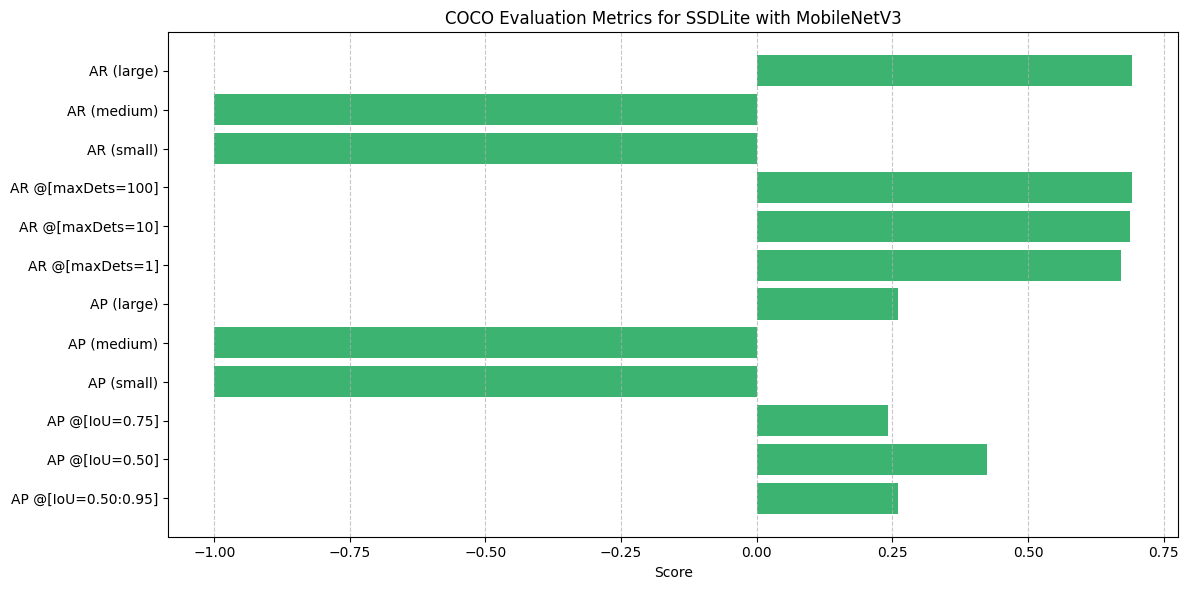

In [ ]:
import os
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt

class RoboflowYOLODataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        while True:
            img_filename = self.image_files[idx]
            img_path = os.path.join(self.images_dir, img_filename)
            label_path = os.path.join(self.labels_dir, img_filename.replace(".jpg", ".txt").replace(".png", ".txt"))

            image = Image.open(img_path).convert("RGB")
            w, h = image.size

            boxes, labels = [], []

            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) != 5:
                            continue
                        class_id, x_center, y_center, width, height = map(float, parts)
                        x_center *= w
                        y_center *= h
                        width *= w
                        height *= h
                        x_min = x_center - width / 2
                        y_min = y_center - height / 2
                        x_max = x_center + width / 2
                        y_max = y_center + height / 2
                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(int(class_id) + 1)

            if not boxes:
                idx = (idx + 1) % len(self.image_files)
                continue

            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            image_id = torch.tensor([idx])
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

            target = {
                "boxes": boxes,
                "labels": labels,
                "image_id": image_id,
                "area": area,
                "iscrowd": iscrowd,
            }

            if self.transforms:
                image = self.transforms(image)

            return image, target

transform = T.Compose([T.ToTensor()])

train_dataset = RoboflowYOLODataset(
    images_dir=r"C:\Users\gabri\Downloads\Cars-Dataset-1\train\images",
    labels_dir=r"C:\Users\gabri\Downloads\Cars-Dataset-1\train\labels",
    transforms=transform
)

val_dataset = RoboflowYOLODataset(
    images_dir=r"C:\Users\gabri\Downloads\Cars-Dataset-1\valid\images",
    labels_dir=r"C:\Users\gabri\Downloads\Cars-Dataset-1\valid\labels",
    transforms=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=None, num_classes=3)
model.load_state_dict(torch.load("ssdlite_mobilenetv3_cars.pth", map_location=device))  
model.to(device)
model.eval()

coco_gt = COCO(r"C:\Users\gabri\Downloads\Cars-Dataset-2\valid\_annotations.coco.json") 

def coco_evaluate(model, data_loader, device, coco_gt):
    model.eval()
    results = []
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        with torch.no_grad():
            outputs = model(images)
        for i, output in enumerate(outputs):
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            image_id = targets[i]["image_id"].item()
            for box, score, label in zip(boxes, scores, labels):
                x1, y1, x2, y2 = box
                width = x2 - x1
                height = y2 - y1
                results.append({
                    "image_id": int(image_id),
                    "category_id": int(label),
                    "bbox": [float(x1), float(y1), float(width), float(height)],
                    "score": float(score)
                })

    if not results:
        print("No detections to evaluate.")
        return []

    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval.stats

coco_metrics = coco_evaluate(model, val_loader, device, coco_gt)

metric_labels = [
    "AP @[IoU=0.50:0.95]",
    "AP @[IoU=0.50]",
    "AP @[IoU=0.75]",
    "AP (small)",
    "AP (medium)",
    "AP (large)",
    "AR @[maxDets=1]",
    "AR @[maxDets=10]",
    "AR @[maxDets=100]",
    "AR (small)",
    "AR (medium)",
    "AR (large)"
]

plt.figure(figsize=(12, 6))
plt.barh(metric_labels, coco_metrics, color='mediumseagreen')
plt.title("COCO Evaluation Metrics for SSDLite with MobileNetV3")
plt.xlabel("Score")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.optim as optim
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to freeze BatchNorm layers
def freeze_bn(m):
    if isinstance(m, torch.nn.BatchNorm2d):
        m.eval()

num_classes = 3  
modelssd = ssdlite320_mobilenet_v3_large(
    pretrained=False,
    weights_backbone="DEFAULT",
    num_classes=num_classes
)
modelssd.to(device)
modelssd.apply(freeze_bn)  #  Freezing BatchNorm 

# Application of similar optimizer and learning rate scheduler setup
params = [p for p in modelssd.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10

for epoch in range(num_epochs):
    modelssd.train()

    # Initialization of loss and accuracy variables during training
    total_loss = 0.0
    correct = 0
    total = 0

    for images, targets in train_loader:
        if len(images) <= 1:            # Skipping of batches if less than 2 images
            continue  

        # Moving images and targets to the device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass and loss calculation
        loss_dict = modelssd(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

        # Evaluation of accuracy on the validation set
        with torch.no_grad():
            modelssd.eval()
            preds = modelssd(images)
            modelssd.train()

            for pred, target in zip(preds, targets):
                pred_labels = pred['labels']
                true_labels = target['labels']
                n = min(len(pred_labels), len(true_labels))
                if n > 0:
                    correct += (pred_labels[:n] == true_labels[:n]).sum().item()
                    total += n

    lr_scheduler.step()

    avg_loss = total_loss / len(train_loader)
    acc = 100.0 * correct / total if total > 0 else 0.0

    # Printing the loss and accuracy for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {acc:.2f}%")

# Saving the trained model with the specified filename
torch.save(modelssd.state_dict(), "ssdlite_mobilenetv3_cars.pth")
print("Model training complete and saved.")

Epoch 1/10 - Loss: 1.6201 - Accuracy: 72.99%
Epoch 2/10 - Loss: 0.9600 - Accuracy: 89.98%
Epoch 3/10 - Loss: 0.7982 - Accuracy: 92.52%
Epoch 4/10 - Loss: 0.6705 - Accuracy: 94.46%
Epoch 5/10 - Loss: 0.5835 - Accuracy: 96.34%
Epoch 6/10 - Loss: 0.5633 - Accuracy: 96.85%
Epoch 7/10 - Loss: 0.5299 - Accuracy: 97.51%
Epoch 8/10 - Loss: 0.5588 - Accuracy: 97.61%
Epoch 9/10 - Loss: 0.5312 - Accuracy: 97.71%
Epoch 10/10 - Loss: 0.5241 - Accuracy: 97.81%
Model training complete and saved.


In [ ]:
import torch
from torchvision.models.detection.ssdlite import ssdlite320_mobilenet_v3_large
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision import transforms
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelssd = ssdlite320_mobilenet_v3_large(pretrained=False, num_classes=3)
modelssd.load_state_dict(torch.load("ssdlite_mobilenetv3_cars.pth", map_location=device))
modelssd.to(device)
modelssd.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
])
val_dataset = CocoDetection(
    root=r"C:\Users\gabri\Downloads\Cars-Dataset-2\valid",
    annFile=r"C:\Users\gabri\Downloads\Cars-Dataset-2\valid\_annotations.coco.json",
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

coco_gt = COCO(r"C:\Users\gabri\Downloads\Cars-Dataset-2\valid\_annotations.coco.json")

def coco_evaluate(model, data_loader, device, coco_gt):
    model.eval()
    results = []
    img_ids = []
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        with torch.no_grad():
            outputs = model(images)
        for i, output in enumerate(outputs):
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            if isinstance(targets[i], list) and len(targets[i]) > 0:
                image_id = targets[i][0]['image_id']
            else:
                # If without annotation, get image_id from dataset
                image_id = val_dataset.ids[data_loader.batch_size * (images[0].shape[0] // data_loader.batch_size) + i]
            if hasattr(image_id, "item"):
                image_id = image_id.item()
            img_ids.append(image_id)
            for box, score, label in zip(boxes, scores, labels):
                x1, y1, x2, y2 = box
                width = x2 - x1
                height = y2 - y1
                result = {
                    "image_id": int(image_id),
                    "category_id": int(label),
                    "bbox": [float(x1), float(y1), float(width), float(height)],
                    "score": float(score)
                }
                results.append(result)
    if len(results) == 0:
        print("No detections to evaluate.")
        return 0.0
    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats[0]  

map_score = coco_evaluate(modelssd, val_loader, device, coco_gt)
print(f"COCO mAP: {map_score:.4f}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.39s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.74s).
Accumulating evaluation results...
DONE (t=0.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.883
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.981
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.948
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.883
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.907
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

In [ ]:
# (Optional) Performing video inference on this trained model
import cv2
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.models.detection.ssdlite import SSDLite320_MobileNet_V3_Large_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3  
confidence_threshold = 0.5

# Loading the trained SSDLite320 model
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
model = ssdlite320_mobilenet_v3_large(pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load("ssdlite_mobilenetv3_cars.pth", map_location=device))
model.to(device)
model.eval()

class_names = ["__background__", "Sedan", "SUV"]  

# Performing Video Inference
input_path = "56310-479197605_tiny.mp4"
output_path = "output_ssd_annotated.mp4"

# Processing the video file. Setup remains consistent from the previous model   
cap = cv2.VideoCapture(input_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_tensor = F.to_tensor(image).to(device)

    with torch.no_grad():
        outputs = model([image_tensor])[0]

    for box, label, score in zip(outputs["boxes"], outputs["labels"], outputs["scores"]):
        if score >= confidence_threshold:
            x1, y1, x2, y2 = map(int, box)
            class_name = class_names[label]
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(frame, f"{class_name}: {score:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    out.write(frame)

cap.release()
out.release()
print("SSD video inference complete. Saved to:", output_path)

SSD video inference complete. Saved to: output_ssd_annotated.mp4
